# 增强对抗训练的语言理解
## 摘要：
对抗训练将保留标记的输入扰动的最大风险降至最低，已被证明是改进语言模型泛化的有效方法。在这项工作中，我们提出了一种新的对抗训练算法FreeLB，它通过在单词嵌入中加入对抗扰动并最小化在输入样本周围不同区域内的结果对抗风险，从而提高了嵌入空间的鲁棒性和不变性。为了验证该方法的有效性，我们将其应用于自然语言理解和常识推理任务的基于Transformer的模型。在GLUE benchmark上的实验表明，只应用于finetuning阶段，可以将BERT-based model的整体测试分数从78.3提高到79.4，将RoBERTa-large model的整体测试分数从88.5提高到88.8。此外，该方法在ARC-Easy和ARC-Challenge上的单模型测试精度分别达到了85.44%和67.75%。在CommonsenseQA基准上的实验进一步证明，FreeLB可以被推广，并提高RoBERTa-large模型在其他任务上的性能。



# 1.介绍
对抗训练是一种建立稳健神经网络的方法。在对抗性训练中，小批量的训练样本会受到对抗性扰动的污染(这些变化很小，但会导致误分类)，然后用于更新网络参数，直到得到的模型学会抵抗这种攻击。对抗性训练最初被认为是一种增强机器学习系统安全性的手段，特别是对于自动驾驶汽车和版权检测等安全关键系统。

在这篇论文中，我们将注意力从对抗性训练的安全益处上转移开，转而研究它对泛化的影响。虽然对抗性训练增强了鲁棒性，但计算机视觉研究人员普遍认为它与泛化不一致，在CIFAR-10中对未损坏图像的分类准确率下降了10%，在Imagenet中下降了15%。令人惊讶的是，人们对语言模型观察到相反的结果，表明对抗性训练可以提高泛化和鲁棒性。

我们将表明，对抗性训练可以显著提高许多语言理解任务中最先进模型的性能。特别地，我们提出了一种新的对抗性训练算法，称为FreeLB (Free Large-Batch)，它将对抗性扰动添加到词嵌入中，并最小化围绕输入样本的对抗性损失。该方法利用了最近提出的“Free”训练策略，在不同的范数约束下，在不增加PGD(投影梯度下降法)训练的前提下，以不增加额外成本的方式，扩大了包含多种多样的对抗性样本的批量，使我们能够在大规模的、最先进的模型上进行这种多样化的对抗性训练。我们观察到使用FreeLB训练的模型在嵌入空间中增强了鲁棒性和不变性，这与泛化正相关。

我们进行了综合实验来评估各种对抗性训练算法在最先进的语言理解模型和任务上的性能。在与标准PGD、FreeAT和YOPO的比较中，FreeLB是我们评估的数据集和模型的最佳选择。使用FreeLB，我们在几个重要的语言理解基准测试上获得了最新的结果。在GLUE基准测试中，FreeLB将BERT-base模型的性能从78.3提升到79.4。RoBERTa-large模型在GLUE基准上的整体得分也从88.5提高到了88.8，大部分子任务都取得了最好的结果。实验还表明FreeLB可以提高RoBERTa-large在问题回答任务(如ARC和CommonsenseQA基准测试)上的性能。我们还提供了一个全面的消融研究和分析，以证明我们的培训过程的有效性。



# 2.相关工作




## 2.1对抗训练
为了提高神经网络对对抗实例的鲁棒性，人们提出了许多防御策略和模型，其中基于PGD的对抗训练被广泛认为是最有效的，因为它在很大程度上避免了模糊梯度问题。提出了一种基于交叉熵损失的极小极大问题的对抗性训练算法，该算法通过多个投影梯度上升步和随机梯度下降步来可靠地实现。

尽管Athalye等人已经证明了PGD可以避免混淆的梯度，但是Qin等人的研究表明，当K值较小时，基于PGD的对抗训练仍然会导致高度卷积和非线性的损失曲面，在较强的对手下很容易被打破。因此，为了有效，基于PGD的对抗训练的成本远远高于传统训练。为了降低这一成本，Shafahi等人提出了一种“Free”的对抗训练算法，它可以在单次向后传递的同时更新模型参数和对抗扰动。Zhang等人使用类似的公式，通过在第一层限制其大多数对抗性更新，有效地减少了完全向前和向后传播的总数。

## 2.2文本的敌人
对抗性实例的研究主要集中在图像领域，近年来在文本领域引起了广泛关注。以前关于文本对手的工作集中于在黑箱设置中创建对抗性示例的启发方法，或者特定的任务。Jia & Liang提出在输入文档中增加一些分散注意力的句子，从而导致错误的分类。Zhao等人使用GANs将输入数据投射到一个潜在空间，并搜索接近原始实例的对手，从而生成文本对手。在机器翻译系统中，Belinkov和Bisk使用合成或自然噪声来处理句子中的每个单词。Iyyer等人提出了一种基于反向翻译数据的神经意译模型来产生具有不同句子结构的意译。与以往的工作不同，我们的工作不是提供实际的对抗性例子，而是利用对抗性训练来帮助自然语言理解。


我们不是第一个发现健壮的语言模型可能表现得更好的人。Miyato等人将对抗性和虚拟对抗性训练扩展到文本领域，以提高半监督分类任务的性能。Ebrahimi等人提出了一个字符/单词来代替工艺攻击，并展示了在训练中使用对抗性的例子使模型更加健壮。Ribeiro等人的研究表明，对抗性攻击可以作为调试NLP模型的一个有价值的工具。Cheng等人也发现，工艺对抗性的例子可以显著地帮助神经机器翻译。值得注意的是，这些研究集中在简单的模型或文本生成任务上。我们的工作探索更深/更大的基于转换的模型，如何有效地逆向攻击它们，以及如何提高挑战性问题的性能。

# 3 语言理解的对抗性训练
预先训练的大型语言模型，如BERT和RoBERTa，已被证明对下游任务非常有效。我们的目标是进一步提高这些预训练语言模型在下游语言理解任务上的泛化能力，提高它们在对这些任务进行微调时的嵌入空间鲁棒性。我们通过创建“虚拟的”对抗性例子来实现这一目标,然后对这些对抗性嵌入执行参数更新。为语言创建实际的对抗性例子是困难的;即使有最先进的语言模型作为指导，我们仍然不清楚如何在没有人工评估的情况下通过单词/字符替换来构建保存标签的对抗性示例，因为每个单词/字符的含义取决于上下文Ribeiro等人。由于我们只对对抗性训练的效果感兴趣，而不是生成实际的对抗性示例，所以我们使用基于梯度的方法将范数有界对抗性扰动添加到输入语句的嵌入中。请注意，我们的基于嵌入的对手严格来说比传统的基于文本的对手更强大，因为我们的对手可以对文本域中不可能的词嵌入进行操作。

对于使用字节对编码(BPE)在子单词级别编码文本的模型，我们的对手只修改连接的BPE嵌入，而不改变句子表示的其他组件(例如，位置编码)。表示输入子单词的一热表示序列为Z = [z1, z2，…]、锌),嵌入矩阵为V,和语言模型(编码器)作为一个函数y = fθ(X), X = V Z, y的输出模型,θ表示所有可学的参数包括嵌入矩阵V。我们加入敌对的扰动δ嵌入,使预测变得y′= fθ(X +δ)。为了保护,我们限制δ的规范的语义,很小,和假设模型的预测扰动后没有变化。这个公式类似于Miyato等人，不同之处在于我们不需要X被标准化。

## 3.1 对抗训练-PGD
标准对抗训练旨在找到一组参数θ∗最小化任何δ的最大风险在一个标准球:
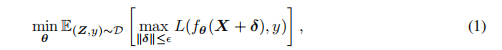

其中为数据分布，y为标号，L为损失函数。我们使用弗罗贝尼乌斯规范来约束δ。对于神经网络，外部的“最小”是非凸的，内部的“最大值”是非凹的。尽管如此，Madry等人证明了这个鞍点问题可以通过SGD可靠地解决外部最小化，而通过PGD(大规模约束优化的标准方法，参见Combettes & Pesquet和Goldstein等人)可靠地解决内部最大化。特别是,δFǫ的约束,与一个额外的损失函数是局部线性假设,PGD需要以下步骤(步骤大小α)在每个迭代中:
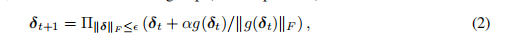

g(δt) =δL (fθ(X +δt), y)的梯度是δ,损失和ΠǁδǁF≤ǫ执行ǫ-ball投影。为了实现高水平的鲁棒性，在训练过程中需要多步对抗的例子，这在计算上是昂贵的。K-step PGD (K-PGD)需要K个前后通过网络，而标准SGD更新只需要一个。结果，对抗性训练中的对手生成步骤将运行时增加了一个数量级——当训练大型的最先进的语言模型时，这是一个灾难性的数量。

## 3.2大批量免费对抗训练
在PGD的内部上升阶段，在计算输入梯度时，几乎不需要任何开销就可以获得参数的梯度。根据这一观察，FreeAT和YOPO被建议加速对抗性训练。它们的稳健性和泛化能力与标准的pgd训练模型相当，并且只使用与自然训练相同或稍微多一点的前向-后向通道数。FreeAT在参数上下降一步，在扰动上上升K步。因此,当最优δθ高度相关,δt是L最大化的最优(fθt (X +δ),y),因为提升一步δt−1δt基于梯度θL (fθt−1 (X +δt−1), y)在θt−1。与FreeAT不同的是，YOPO从每个上升步骤累积参数的梯度，并且在K个内部上升步骤之后只更新一次参数。YOPO还主张在每次反向传播后，将第一个隐含层的梯度作为一个常数，利用该常数与网络第一层的雅可比矩阵的乘积，对对手进行多次额外的更新。有趣的是，支持额外更新步骤的分析假设了一个两次连续可微的损失，这对于他们实验的基于残差的神经网络来说是不成立的，因此这种算法成功的原因仍然是模糊的。我们在第4.3节中对YOPO和我们的方法进行了实证比较。

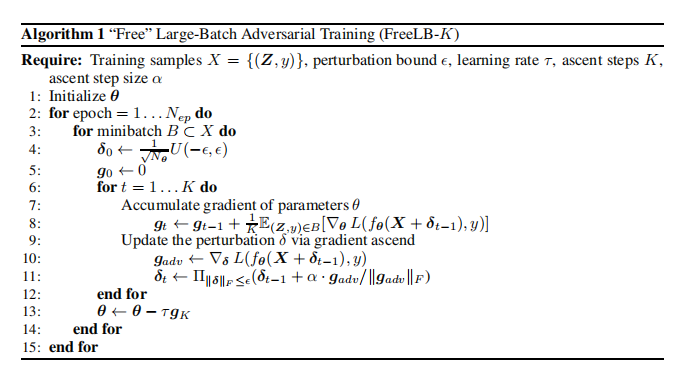
为了最大获得更好的解决方案,避免基本限制函数类,我们建议FreeLB,执行多个PGD迭代工艺敌对的例子,同时积累“免费”参数梯度θL在每个迭代中。之后,它更新模型参数θ一下子积累梯度。整个过程如算法1所示,在X +δt是一个近似相交的两个球内的局部最大值= BX +δ0(αt)∩BX(ǫ)。通过血统一步X +δ0平均梯度,…,X +δK−1,我们大约优化以下目的:
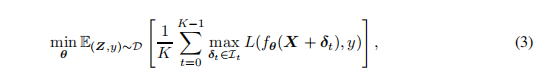

相当于替换原有的批处理X k *大的虚拟批,组成的样本X +δ0嵌入的……,X +δK−1。与基于pgd的对抗性训练(Eq. 1)相比，FreeLB在几乎没有开销的情况下，在每个训练样本附近的单个估计值点上最小化最大风险。


从直观上看，FreeLB是一种比PGD泛化误差更小的学习方法。Sokolic等人证明了t√he对一组t变换不变的学习方法的泛化误差可能比非不变学习方法小t。根据他们的理论,FreeLB可以更自然的训练显著提高,因为FreeLB执行不变性K的敌人从一组到K不同的规范约束,1,PGD只执行不变性约束ǫ单一标准。
从经验上看，与PGD相比，FreeLB在嵌入空间上确实具有更高的鲁棒性和不变性，这是因为使用FreeLB训练的模型在X附近的最大损失增加要小于PGD。详见第4.3节。从理论上讲，这种改进的鲁棒性可以得到更好的泛化，这与我们的实验是一致的。Qin等人也论证了基于pgd的方法在K值较小时，会导致输入样本附近出现高度卷积和非线性的损失曲面，表明该方法缺乏鲁棒性。

## 3.3当对抗性训练遇到dropout
通常情况下，对抗性训练不会与dropout一起使用。然而，对于像RoBERTa这样的语言模型，dropout是在finetuning阶段使用的。dropout后在实践中,每个提升步骤的算法优化δ1是一个不同的网络。具体地说，将dropout掩码表示为m，每个入口mi∼Bernoulli(p)。FreeAT类似于我们的分析,提升一步从δt−1δt基于∇δL (fθ(太−1)(X +δt−1), y),所以δt次优L (fθ(mt) (X +δ),y)如果θ和δ是高度相关的。这里θ(m)辍学面具下的有效参数m。

更合理的解决方案是在每一步中使用相同的m。应用辍学时任何净——工作,θ的目标是最小化的期望损失在不同网络由辍学面具,这是通过减少蒙特卡罗估计预期的损失。我们的目标是:
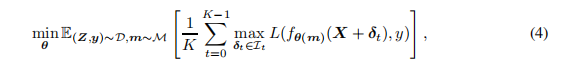
其中1样本蒙特卡罗估计应该是。这类似于在Gal和Ghahramani中对RNNs应用变分Dropout。

# 4实验
在本节中，我们通过对GLUE、ARC和CommonsenseQA这三种NLP基准的大量实验，对FreeLB进行了全面的分析。我们还将FreeLB的鲁棒性和泛化性与其他对抗训练算法进行了比较，以证明其优势。附录中提供了更多的实验细节。